# Modersmærkekræft recognition

In [1]:
train_dir = "Data Set Ordered/training data/"
val_dir = "Data Set Ordered/validation data/"
test_dir = "Data Set Ordered/test data/"

## Iteration 1

In [71]:
from keras.applications import MobileNetV3Small
from keras.layers import Dense, Flatten
from keras.models import Model
from keras.optimizers import SGD
from keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      preprocessing_function=preprocess_input,
)


# Train generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size=32,
    target_size=(224, 224),
    class_mode='categorical',
)

# Validation generator
validation_generator = train_datagen.flow_from_directory(
    val_dir,
    batch_size=32,
    target_size=(224, 224),
    class_mode='categorical',
)

# Validation generator
test_generator = train_datagen.flow_from_directory(
    test_dir,
    batch_size=32,
    target_size=(224, 224),
    class_mode='categorical',
)

base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
      layer.trainable = False

  # Add custom layers for classification
x = base_model.output
x = Flatten()(x)
preds = Dense(7,activation='softmax')(x)

# Define the complete model
model = Model(inputs=base_model.input, outputs=preds)

sgd = SGD()

# Compile model - make it trainable
model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])



Found 10015 images belonging to 7 classes.
Found 193 images belonging to 7 classes.
Found 1512 images belonging to 7 classes.


In [72]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping

# Define the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath='models/best_model_iteration_1.h5',
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    verbose=1
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',  
    patience=15,          
    min_delta=0.001      
)

# Train the model with the callback
history2 = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    verbose=1,
    callbacks=[checkpoint_callback, early_stopping_callback]
)

Epoch 1/50
313/313 [==============================] - ETA: 0s - loss: 8.4423 - accuracy: 0.6684
Epoch 1: val_loss improved from inf to 5.94430, saving model to models/best_model_iteration_1.h5
313/313 [==============================] - 31s 92ms/step - loss: 8.4423 - accuracy: 0.6684 - val_loss: 5.9443 - val_accuracy: 0.7409
Epoch 2/50
313/313 [==============================] - ETA: 0s - loss: 4.5675 - accuracy: 0.7583
Epoch 2: val_loss did not improve from 5.94430
313/313 [==============================] - 33s 105ms/step - loss: 4.5675 - accuracy: 0.7583 - val_loss: 8.3247 - val_accuracy: 0.5596
Epoch 3/50
313/313 [==============================] - ETA: 0s - loss: 3.1558 - accuracy: 0.8072
Epoch 3: val_loss improved from 5.94430 to 2.62422, saving model to models/best_model_iteration_1.h5
313/313 [==============================] - 32s 102ms/step - loss: 3.1558 - accuracy: 0.8072 - val_loss: 2.6242 - val_accuracy: 0.7824
Epoch 4/50
313/313 [==============================] - ETA: 0s - lo

Balanced Accrucay: 0.4544381064284993
Accuracy on test set: 0.7023809552192688
F1 Score: 0.6968233065172709


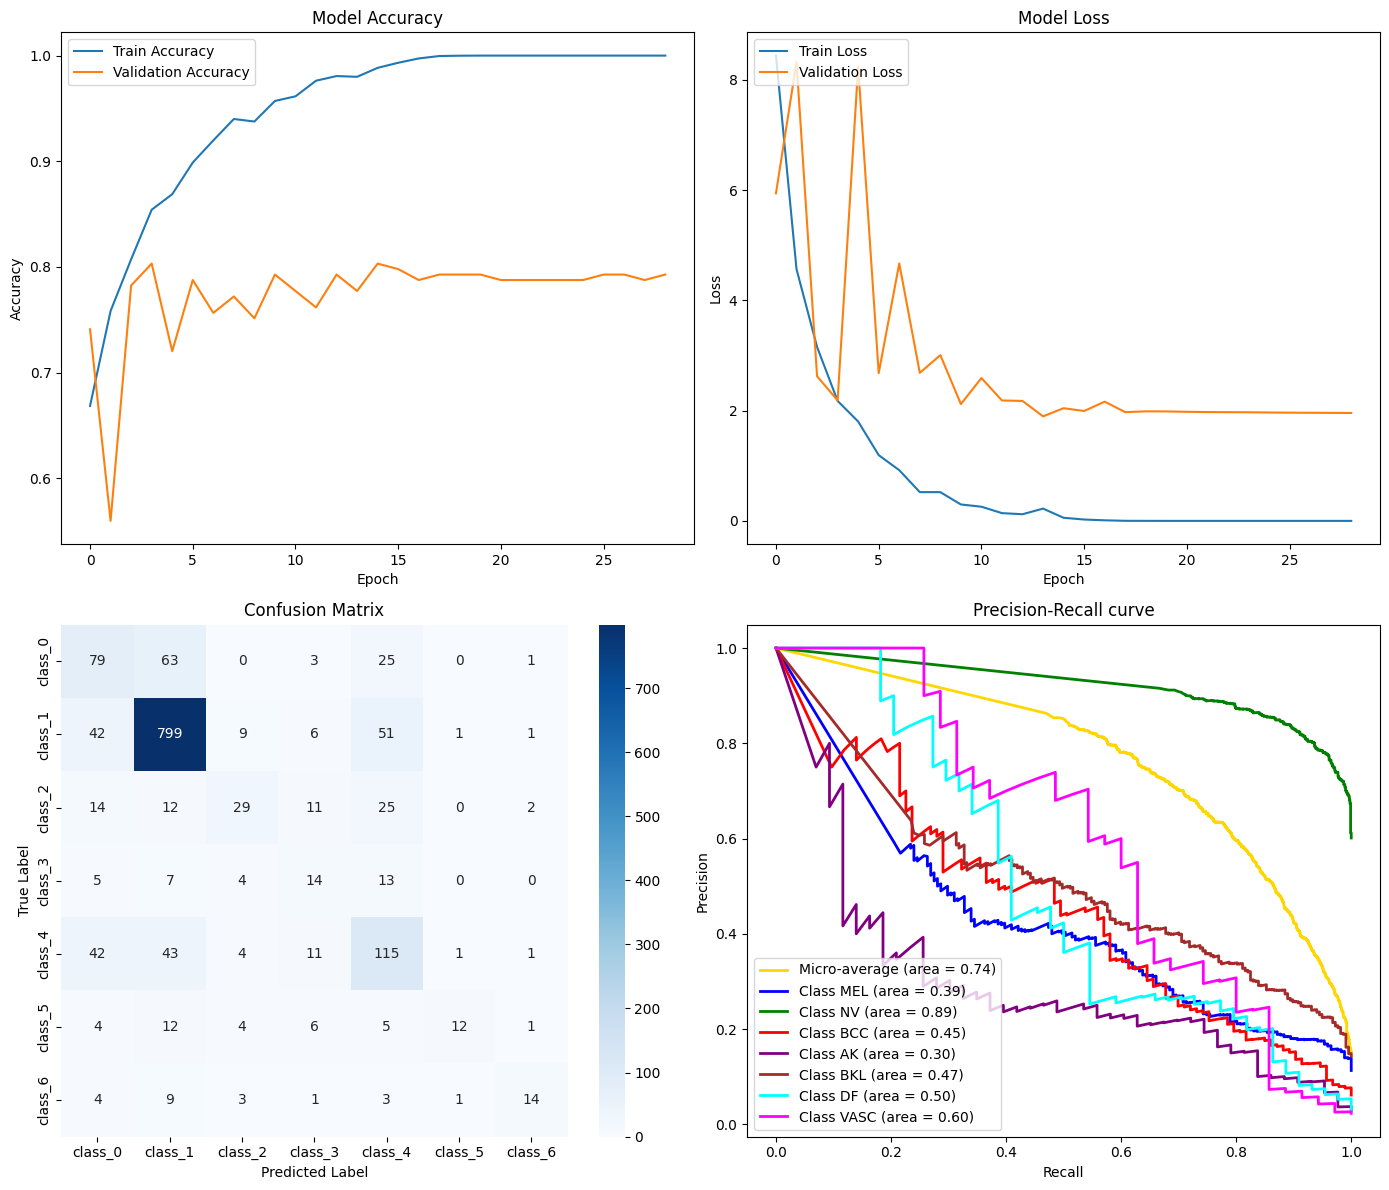

In [73]:
from tensorflow.keras.models import load_model

model = load_model('models/best_model_iteration_1.h5')

show_all_plots(history2, model, test_generator)

### What did we learn????

- Overfitting:
    - yes, we think
- Efficiency:
    - Super fint - den er hurtig (30 sec per epoch - 100=51 min)
- Performance:
    - Accuracy -> train=100, val=77.72, test: 70.42
    - loss -> train=fuckinglav, val=1.84854, test=4.7873

Takaways:
- We do not overfit, so we can try with a more complex model?
- We did not expect it to learn to differentiate between the 7 classes as they are very unbalanced.
- We did not expect it to learn this much
- It doesnt learn that well for val/test and there is a large gap between train and the others

What to do next time?
- Experiment with Learning Rate
    - we can observe that model has "plateaued", meaning that the validation loss neither goes up or down, 
    with the use of a Learning Rate Scheduler we could force the model out of the plateau and maybe achieve a lower loss (maybe?).
    - week 6 slide11
- Experiment with Regularization 
    - we can observe that there is a significant difference between the loss in train and val. This can be tackle by implementing regularization techniques.
        - Data augmentation
        - Early Stopping! (always do this)
        - Dropout
        - Add Noise when training

## Iteration 2

This is a script to test what learning rate we should use (and scheduler)

In [2]:
import os

# Set CUDA_LAUNCH_BLOCKING to 1
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# Now you can import TensorFlow and run your code
import tensorflow as tf

# Your training code here


In [ ]:

from keras.optimizers import SGD
from tensorflow.keras import optimizers
from keras.callbacks import LearningRateScheduler
import numpy as np
from keras.applications import MobileNetV3Small
from keras.layers import Dense, Flatten
from keras.models import Model
from keras.optimizers import SGD
from keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt

batch_size = 32
epochs = 50


train_datagen = ImageDataGenerator(
      preprocessing_function=preprocess_input,
)


# Train generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size=32,
    target_size=(224, 224),
    class_mode='categorical',
)

# Validation generator
validation_generator = train_datagen.flow_from_directory(
    val_dir,
    batch_size=32,
    target_size=(224, 224),
    class_mode='categorical',
)

# Validation generator
test_generator = train_datagen.flow_from_directory(
    test_dir,
    batch_size=32,
    target_size=(224, 224),
    class_mode='categorical',
)

base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

# Add custom layers for classification
x = base_model.output
x = Flatten()(x)
preds = Dense(7,activation='softmax')(x)

# Define the complete model
model = Model(inputs=base_model.input, outputs=preds)

sgd = SGD()

# Compile model - make it trainable
model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])






# Custom callback to record the learning rate at each epoch
class LearningRateTracker(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        # Check if learning rate is a callable schedule (like InverseTimeDecay)
        if callable(self.model.optimizer.learning_rate):
            # Get current learning rate by calling the schedule with the current step
            step = self.model.optimizer.iterations
            lr = self.model.optimizer.learning_rate(step).numpy()
        else:
            # Directly access learning rate if it's a fixed value
            lr = self.model.optimizer.learning_rate.numpy()
        
        if not hasattr(self, 'learning_rates'):
            self.learning_rates = []
        self.learning_rates.append(lr)


# To store learning rates per decay strategy
learning_rates_dict = {}



total_number_of_images = train_generator.samples



initial_lr = 0.01
decay_rate = initial_lr * 0.01
# Learning rate decay functions
def linear_decay(epoch, initial_lr=initial_lr, decay_rate=decay_rate):
    return initial_lr - decay_rate * epoch

initial_lr = 0.01
decay_rate = 0.1
def inverse_sqrt_decay(epoch, initial_lr=initial_lr, decay_rate=decay_rate):
    return initial_lr / np.sqrt(1 + decay_rate * epoch)

initial_lr = 0.01
drop = 0.5
epochs_drop = 1/5 * epochs
def step_decay(epoch, initial_lr=initial_lr, drop=drop, epochs_drop=epochs_drop):
    return initial_lr * (drop ** np.floor((1 + epoch) / epochs_drop))


fraction = 0.1
total_number_trainingsteps = (total_number_of_images / batch_size) * epochs

initial_learning_rate = 0.1
decay_steps = total_number_trainingsteps * 0.1
decay_rate = 0.5
inverse_time_decay = optimizers.schedules.InverseTimeDecay(
    initial_learning_rate, decay_steps, decay_rate)


starter_learning_rate = 0.1
end_learning_rate = starter_learning_rate * 0.1 
decay_steps = total_number_trainingsteps * 0.75
power = 0.3

print("decay steps", decay_steps)

polynomial_decay = optimizers.schedules.PolynomialDecay(
    initial_learning_rate=starter_learning_rate,
    decay_steps=decay_steps,
    end_learning_rate=end_learning_rate,
    power=power
)


initial_learning_rate = 0.1
decay_steps = total_number_trainingsteps * 0.1
decay_rate = 0.96
exponential_decay = optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=True)


sgd_configs = {}
#sgd_configs.update({f'cosine_with_warmup_decay': SGD(learning_rate=cosine_with_warmup_decay)})
sgd_configs.update({f'inverse_time_decay': SGD(learning_rate=inverse_time_decay)})
sgd_configs.update({f'polynomial_decay': SGD(learning_rate=polynomial_decay)})
sgd_configs.update({f'exponential_decay': SGD(learning_rate=exponential_decay)})
sgd_configs.update({f'constant': SGD(learning_rate=0.001)})



config_callbacks = {
    'linear_decay': {
        'callback': LearningRateScheduler(lambda epoch: linear_decay(epoch)),
    },
    'inverse_sqrt_decay': {
        'callback': LearningRateScheduler(lambda epoch: inverse_sqrt_decay(epoch)),
    },
    'step_decay': {
        'callback': LearningRateScheduler(lambda epoch: step_decay(epoch)),
    },
}

results = {}

for key in config_callbacks:

    base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    for layer in base_model.layers:
        layer.trainable = False

    # Add custom layers for classification
    x = base_model.output
    x = Flatten()(x)
    preds = Dense(7,activation='softmax')(x)

    # Define the complete model
    model = Model(inputs=base_model.input, outputs=preds)


    # Compile model - make it trainable
    model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])
    lr_tracker = LearningRateTracker()
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=epochs,
        batch_size=batch_size,
        verbose=1,
        callbacks=[config_callbacks[key]['callback'], lr_tracker])

    learning_rates_dict[key] = lr_tracker.learning_rates
    # Evaluate the model on the validation set
    val_loss, val_acc = model.evaluate(validation_generator)
    results[f"{key}"] = history
    print(f'{key} ------>>>>>> Validation Accuracy: {val_acc:.4f}, Validation Loss: {val_loss:.4f}\n')


for key in sgd_configs:

    sgd = sgd_configs[key]

    lr_tracker = LearningRateTracker()

    base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    for layer in base_model.layers:
        layer.trainable = False

    # Add custom layers for classification
    x = base_model.output
    x = Flatten()(x)
    preds = Dense(7,activation='softmax')(x)

    # Define the complete model
    model = Model(inputs=base_model.input, outputs=preds)


    # Compile model - make it trainable
    model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])

    # Train the model
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=epochs,
        batch_size=batch_size,
        verbose=1,
        callbacks=[lr_tracker]
    )

    learning_rates_dict[key] = lr_tracker.learning_rates
    # Evaluate the model on the validation set
    val_loss, val_acc = model.evaluate(validation_generator)
    results[key] = history
    print(f'{key} ------>>>>>> Validation Accuracy: {val_acc:.4f}, Validation Loss: {val_loss:.4f}\n')




# Plotting learning rate decay over time for each configuration
plt.figure(figsize=(12, 8))
for key, lrs in learning_rates_dict.items():
    plt.plot(range(len(lrs)), lrs, label=f'{key} LR decay')

plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Decay Comparison')
plt.legend()
plt.show()

for key, history in results.items():
    print(f"{key}: val_acc: {history.history['val_accuracy'][-1]}, val_loss: {history.history['val_loss'][-1]}")


Found 10015 images belonging to 7 classes.
Found 193 images belonging to 7 classes.
Found 1512 images belonging to 7 classes.
decay steps 11736.328125
Epoch 1/50
313/313 [==============================] - 64s 196ms/step - loss: 8.2374 - accuracy: 0.6707 - val_loss: 3.0076 - val_accuracy: 0.7720 - lr: 0.0100
Epoch 2/50
313/313 [==============================] - 20s 65ms/step - loss: 4.3848 - accuracy: 0.7619 - val_loss: 2.5217 - val_accuracy: 0.7927 - lr: 0.0099
Epoch 3/50
313/313 [==============================] - 20s 65ms/step - loss: 2.7119 - accuracy: 0.8227 - val_loss: 4.8813 - val_accuracy: 0.7150 - lr: 0.0098
Epoch 4/50
313/313 [==============================] - 20s 64ms/step - loss: 2.1482 - accuracy: 0.8469 - val_loss: 3.9077 - val_accuracy: 0.7513 - lr: 0.0097
Epoch 5/50
313/313 [==============================] - 21s 66ms/step - loss: 1.5558 - accuracy: 0.8753 - val_loss: 2.4586 - val_accuracy: 0.8031 - lr: 0.0096
Epoch 6/50
313/313 [==============================] - 21s 66ms/

linear_decay: val_acc: 0.7979274392127991, val_loss: 1.8466776609420776


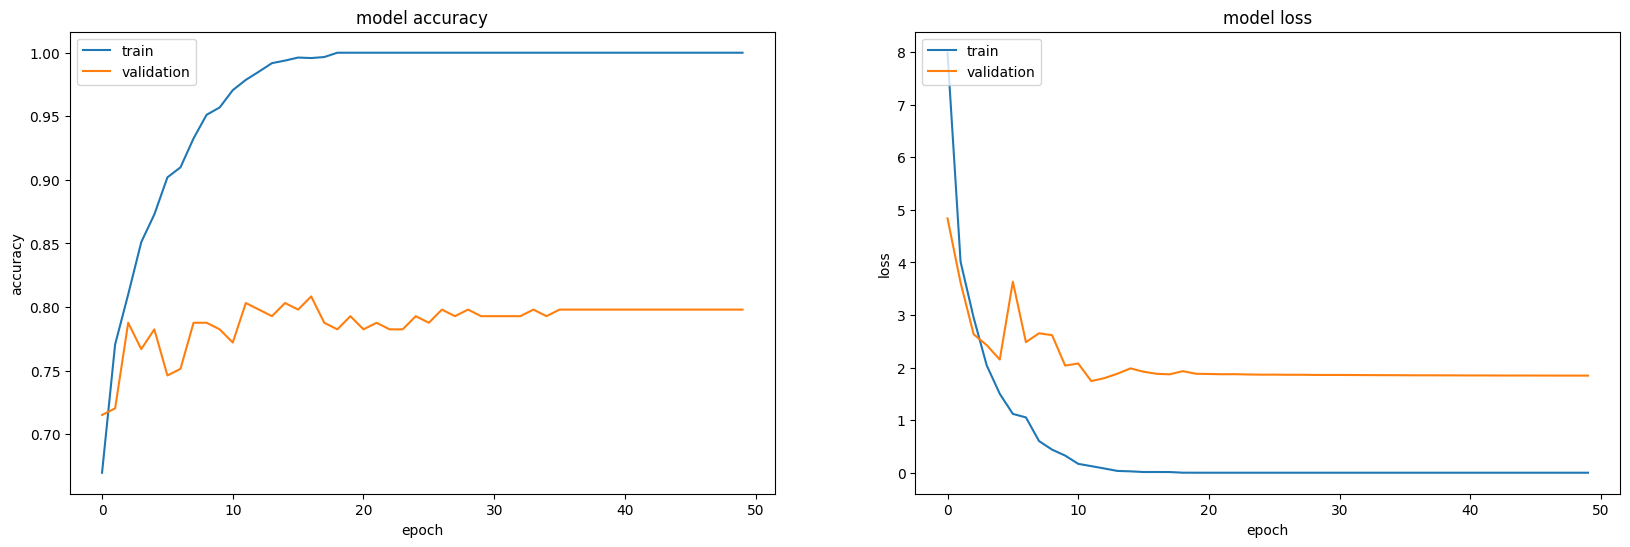

inverse_sqrt_decay: val_acc: 0.7979274392127991, val_loss: 1.557247519493103


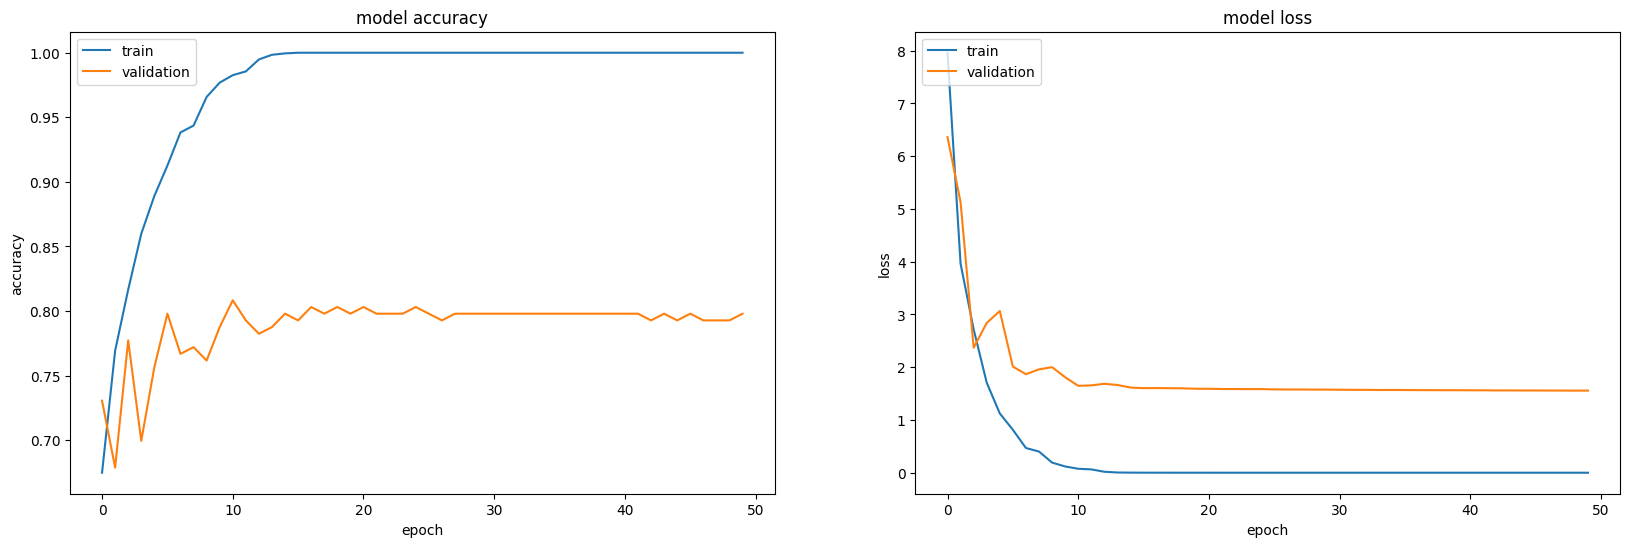

step_decay: val_acc: 0.8082901835441589, val_loss: 1.8573381900787354


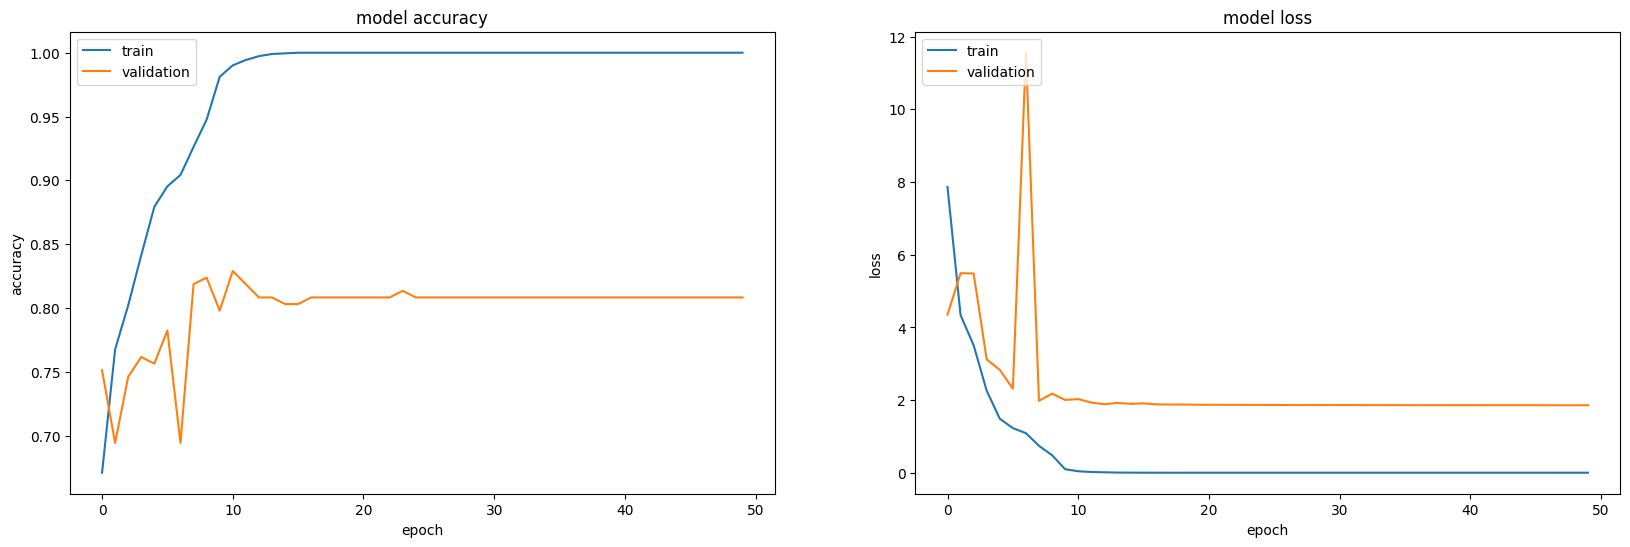

inverse_time_decay: val_acc: 0.7979274392127991, val_loss: 4.162773609161377


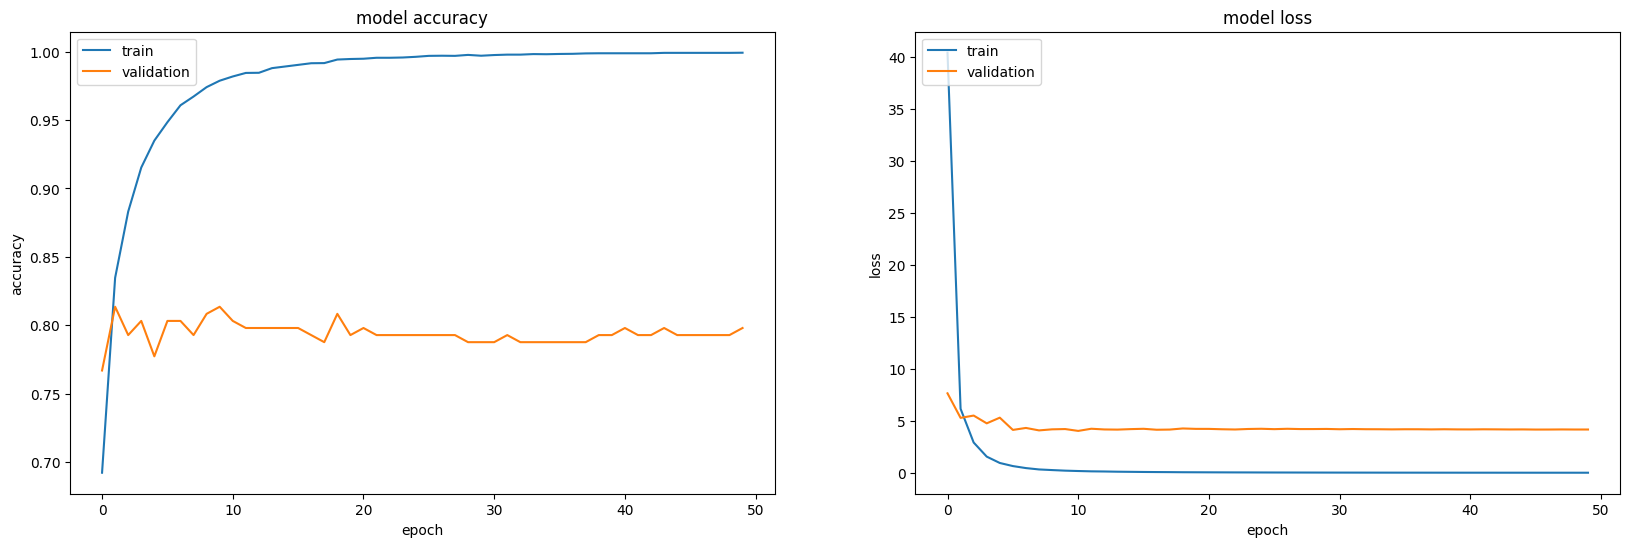

polynomial_decay: val_acc: 0.772020697593689, val_loss: 8.179764747619629


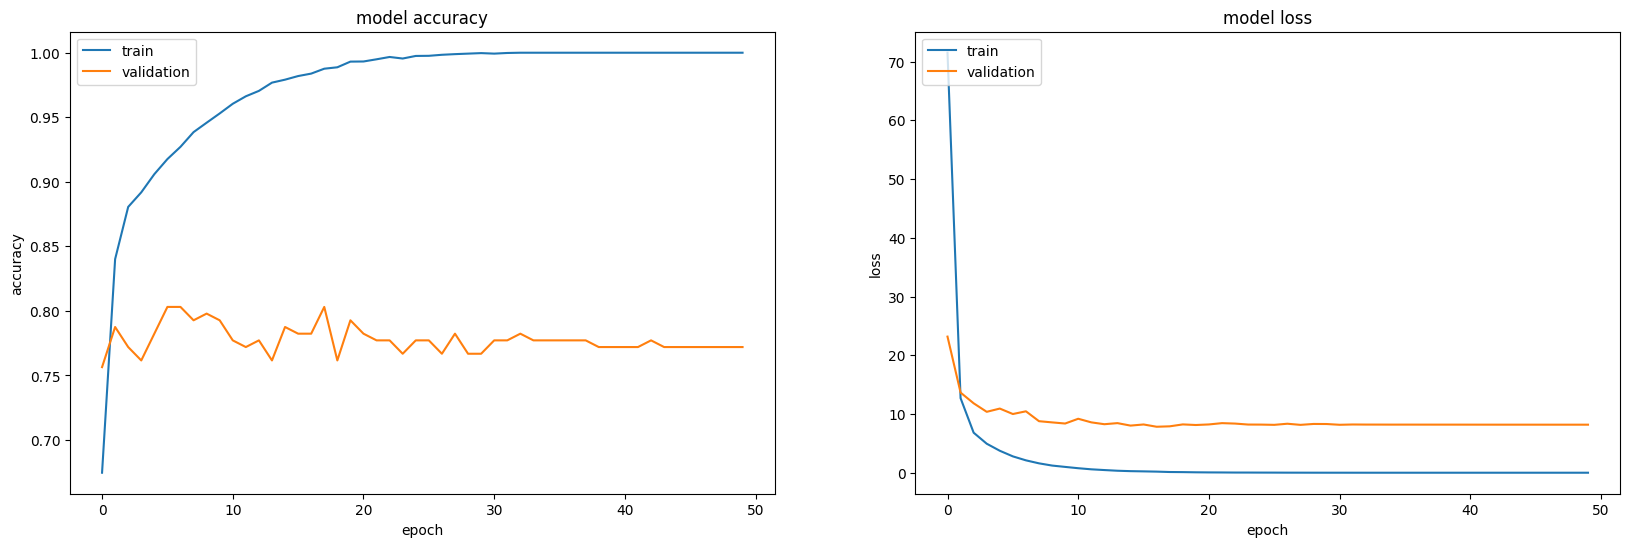

exponential_decay: val_acc: 0.7772020697593689, val_loss: 11.33125114440918


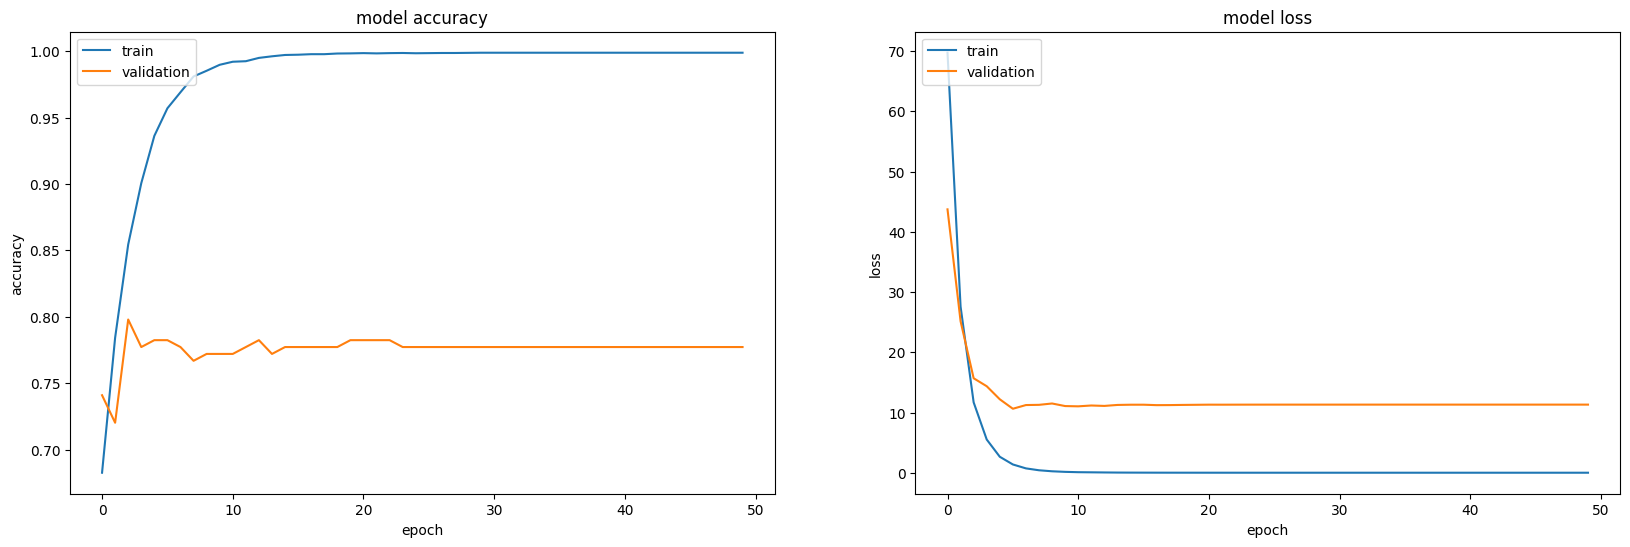

constant: val_acc: 0.787564754486084, val_loss: 0.5415298938751221


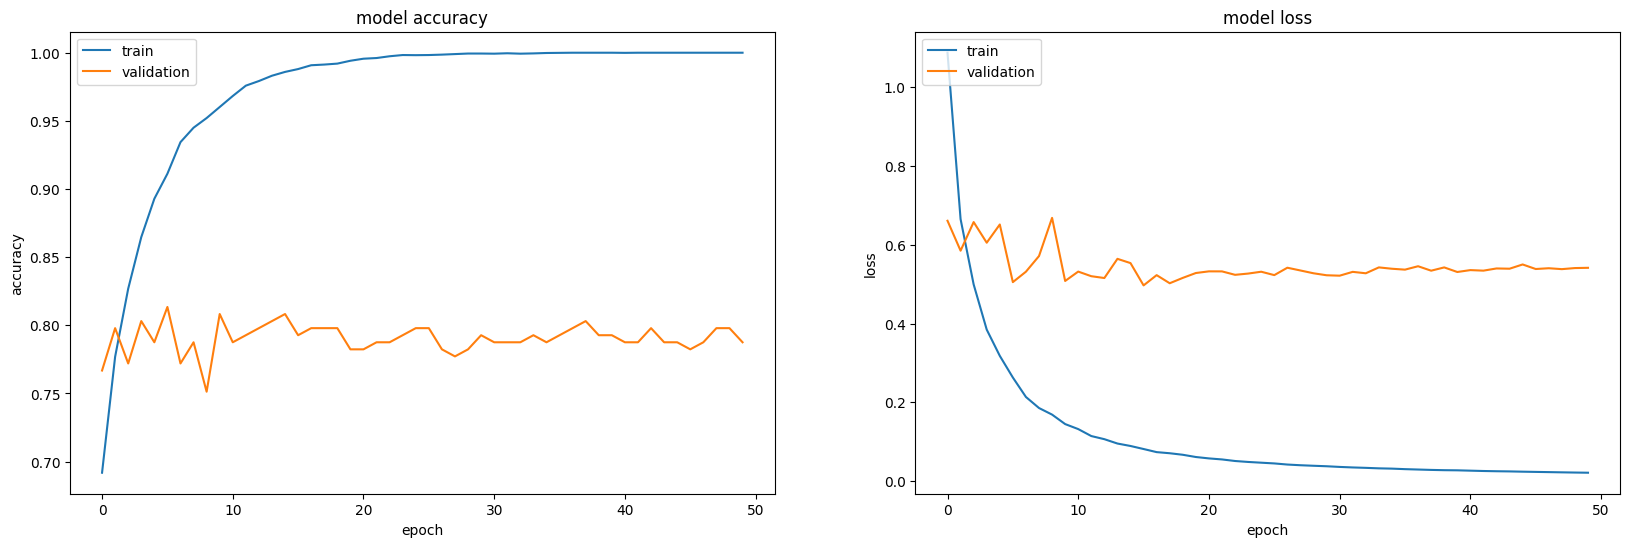

In [8]:
for key, history in results.items():
    print(f"{key}: val_acc: {history.history['val_accuracy'][-1]}, val_loss: {history.history['val_loss'][-1]}")
    show_history(history)

## Iteration 3

Here we experiment with LR rate. In particular we use "Jeremy's approch" with cyclic learning rate.

In [2]:
from keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      preprocessing_function=preprocess_input,
)


# Train generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size=32,
    target_size=(224, 224),
    class_mode='categorical',
)

# Validation generator
validation_generator = train_datagen.flow_from_directory(
    val_dir,
    batch_size=32,
    target_size=(224, 224),
    class_mode='categorical',
)

# Validation generator
test_generator = train_datagen.flow_from_directory(
    test_dir,
    batch_size=32,
    target_size=(224, 224),
    class_mode='categorical',
)


/Users/sebastiangodske/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Found 10015 images belonging to 7 classes.
Found 193 images belonging to 7 classes.
Found 1512 images belonging to 7 classes.


In [9]:
model = CustomModel(number_of_samples=train_generator.samples)

model.compile()

In [10]:
model.fit_epochs(train_generator, validation_generator, epochs=5, checkpoint_path='models/best_model_iteration_3.h5')

Epoch 1/5
313/313 [==============================] - ETA: 0s - loss: 1.0229 - accuracy: 0.6844
Epoch 1: val_loss improved from inf to 0.89050, saving model to models/best_model_iteration_3.h5
313/313 [==============================] - 33s 102ms/step - loss: 1.0229 - accuracy: 0.6844 - val_loss: 0.8905 - val_accuracy: 0.6943
Epoch 2/5


/Users/sebastiangodske/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - ETA: 0s - loss: 0.6953 - accuracy: 0.7553
Epoch 2: val_loss improved from 0.89050 to 0.78447, saving model to models/best_model_iteration_3.h5
313/313 [==============================] - 31s 98ms/step - loss: 0.6953 - accuracy: 0.7553 - val_loss: 0.7845 - val_accuracy: 0.7254
Epoch 3/5
313/313 [==============================] - ETA: 0s - loss: 0.5649 - accuracy: 0.7980
Epoch 3: val_loss improved from 0.78447 to 0.75507, saving model to models/best_model_iteration_3.h5
313/313 [==============================] - 31s 98ms/step - loss: 0.5649 - accuracy: 0.7980 - val_loss: 0.7551 - val_accuracy: 0.7409
Epoch 4/5
313/313 [==============================] - ETA: 0s - loss: 0.4668 - accuracy: 0.8332
Epoch 4: val_loss improved from 0.75507 to 0.72240, saving model to models/best_model_iteration_3.h5
313/313 [==============================] - 31s 98ms/step - loss: 0.4668 - accuracy: 0.8332 - val_loss: 0.7224 - val_accuracy: 0.7565
Epoch 5/5
313/313 [====

All layers have been unfrozen.
32 312.96875 3129.6875
Epoch 1/10
313/313 [==============================] - 122s 385ms/step - loss: 1.1649 - accuracy: 0.6938 - val_loss: 0.9744 - val_accuracy: 0.7513
Epoch 2/10
313/313 [==============================] - 106s 339ms/step - loss: 0.7191 - accuracy: 0.7825 - val_loss: 0.8569 - val_accuracy: 0.7565
Epoch 3/10
313/313 [==============================] - 106s 337ms/step - loss: 0.4309 - accuracy: 0.8566 - val_loss: 1.0052 - val_accuracy: 0.7565
Epoch 4/10
313/313 [==============================] - 109s 349ms/step - loss: 0.2305 - accuracy: 0.9227 - val_loss: 1.0706 - val_accuracy: 0.7306
Epoch 5/10
313/313 [==============================] - 122s 390ms/step - loss: 0.1426 - accuracy: 0.9533 - val_loss: 1.1189 - val_accuracy: 0.7409
Epoch 6/10
313/313 [==============================] - 125s 398ms/step - loss: 0.1026 - accuracy: 0.9631 - val_loss: 1.0903 - val_accuracy: 0.7409
Epoch 7/10
313/313 [==============================] - 116s 371ms/step 

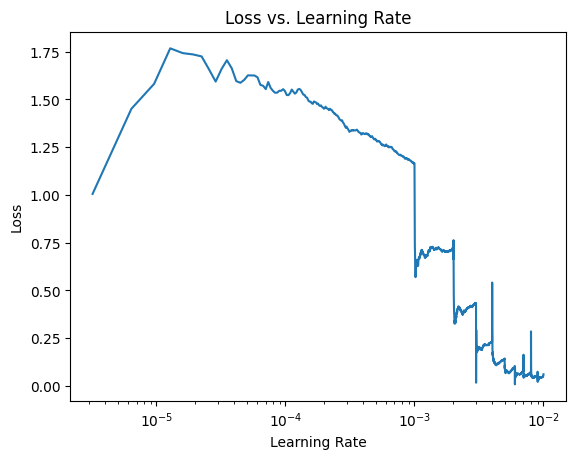

In [11]:
model.unfreeze()
model.lr_find(train_generator, validation_generator)

In [ ]:
model.fit_epochs(train_generator, validation_generator, epochs=50, checkpoint_path='models/best_model_iteration_3.h5', lr=[9e-4, 1e-3])

### What did we learn????

- Overfitting:
    - Big gap between train / val means overfitting (slide 91) it just cant generelize 
- Efficiency:
    - Super fint - den er hurtig (30 sec per epoch - 100=51 min)
- Performance:
    - Accuracy -> train=100, val=82.72, test: 71.42
    - loss -> train=fuckinglav, val=0.56, test=1.22

Takaways:
- We did not expect it to learn to differentiate between the 7 classes as they are very unbalanced.
- We did not expect it to learn this much
- It doesnt learn that well for val/test and there is a large gap between train and the others

Did we do what we wanted?
- a bit, we got a lower loss but we still plateau pretty quickly. It is probably becuase we have better initialization of the lr so the loss doesnt get too crazy but it still need to get lower.

What to do next time?
- Experiment with Learning Rate
    - we can observe that model has "plateaued", meaning that the validation loss neither goes up or down, 
    with the use of a Learning Rate Scheduler we could force the model out of the plateau and maybe achieve a lower loss (maybe?).
    - week 6 slide11
- Experiment with Regularization 
    - we can observe that there is a significant difference between the loss in train and val. This can be tackle by implementing regularization techniques.
        - Data augmentation
        - Early Stopping! (always do this)
        - Dropout
        - Add Noise when training

# Iteration 4

What do we want to do? Regularization!

How?
- More data
- - data augmentation
- - Oversample/undersample
- - Class weight in loss function

What?
- We first try data augmentation - question is how should we distribute the number of pictures per class. 
- - We choose equal dist but we expect that some classes will overfit as we over sample from 200-7000

In [14]:
from homemade_dataloader import HomemadeDataloader
from keras.applications.mobilenet_v3 import preprocess_input
# Directories for each class
project_dir = "/content/gdrive/MyDrive/DeepLearning Project/" #removed space in "My Drive"
project_dir=""
train_dir = project_dir + 'Data Set Ordered/training data/'
validation_dir = project_dir + 'Data Set Ordered/validation data/'
test_dir = project_dir + 'Data Set Ordered/test data/'

dist = [7000,7000,7000,7000,7000,7000,7000]
batch_size = 32
epochs = 100

train_generator = HomemadeDataloader(train_dir, batch_size, (224,224), isValidation=False, preprocess_function=preprocess_input, class_distribuition= dist)

validation_generator = HomemadeDataloader(validation_dir, batch_size, (224,224), isValidation=True, preprocess_function=preprocess_input)

test_generator = HomemadeDataloader(test_dir, batch_size, (224,224), isValidation=True, preprocess_function=preprocess_input)

Found 10015 images belonging to 7 classes (dist says 49000)
Found 193 images belonging to 7 classes (dist says 0)
Found 1512 images belonging to 7 classes (dist says 0)


In [8]:
from models.homemade_model_iteration_3 import HomemadeModel
from tensorflow.keras.callbacks import ModelCheckpoint

model = HomemadeModel()

model, lr_scheduler = model.load_model(number_of_samples=len(train_generator.all_image_indices))

checkpoint_callback = ModelCheckpoint(
    filepath='models/best_model_iteration_4.h5',
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    verbose=1
)

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
    callbacks=[lr_scheduler, checkpoint_callback]
)



Epoch 1/100
1531/1531 [==============================] - ETA: 0s - loss: 1.5115 - accuracy: 0.4801
Epoch 1: val_loss improved from inf to 1.29614, saving model to models/best_model_iteration_4.h5
1531/1531 [==============================] - 378s 246ms/step - loss: 1.5115 - accuracy: 0.4801 - val_loss: 1.2961 - val_accuracy: 0.5833
Epoch 2/100


/Users/sebastiangodske/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1531/1531 [==============================] - ETA: 0s - loss: 1.2225 - accuracy: 0.5707
Epoch 2: val_loss did not improve from 1.29614
1531/1531 [==============================] - 369s 241ms/step - loss: 1.2225 - accuracy: 0.5707 - val_loss: 1.5465 - val_accuracy: 0.5521
Epoch 3/100
1531/1531 [==============================] - ETA: 0s - loss: 1.1574 - accuracy: 0.5893
Epoch 3: val_loss improved from 1.29614 to 1.26060, saving model to models/best_model_iteration_4.h5
1531/1531 [==============================] - 1149s 751ms/step - loss: 1.1574 - accuracy: 0.5893 - val_loss: 1.2606 - val_accuracy: 0.5781
Epoch 4/100
1531/1531 [==============================] - ETA: 0s - loss: 1.1294 - accuracy: 0.6029
Epoch 4: val_loss improved from 1.26060 to 1.02464, saving model to models/best_model_iteration_4.h5
1531/1531 [==============================] - 372s 243ms/step - loss: 1.1294 - accuracy: 0.6029 - val_loss: 1.0246 - val_accuracy: 0.6875
Epoch 5/100
1531/1531 [==============================]

KeyboardInterrupt: 

### Test fir what augmentations we can do

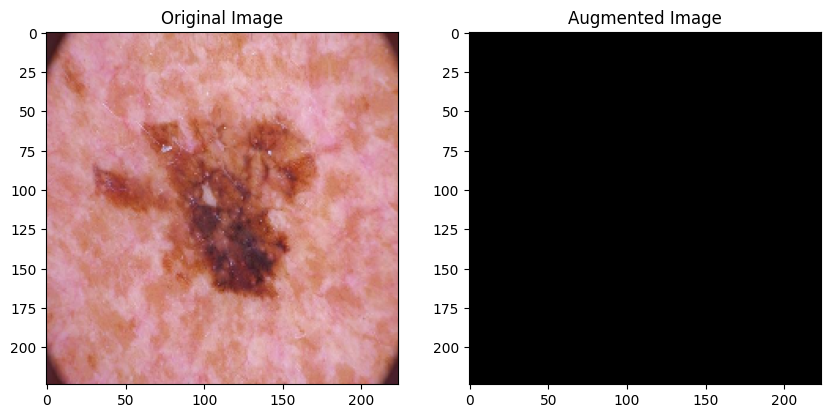

In [243]:
import random
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

# Define the data generator with your specified augmentations
datagen = ImageDataGenerator(
)

#shear_range=50, widht/height 0.2, roation_range=360, brightness_range=[0.3, 1.8], channel_shift_range= random.uniform(20, 50),zoom_range=0.3,


def augment_and_display_image(image_path, datagen):
    # Load and preprocess the image
    image = load_img(image_path, target_size=(224, 224))
    input_array = img_to_array(image)  # Convert image to array
    input_array = np.expand_dims(input_array, 0)  # Add batch dimension

    # Generate an augmented image
    augmented_iter = datagen.flow(input_array, batch_size=1)
    augmented_image = next(augmented_iter)[0].astype('uint8')

    # Plot the original and augmented images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    
    plt.subplot(1, 2, 2)
    plt.imshow(augmented_image)
    plt.title("Augmented Image")
    plt.show()

# Example usage:
image_path = os.path.join(train_dir, "class_0/image_4.jpg")  # Replace with the actual image file path
augment_and_display_image(image_path, datagen)


In [16]:
from itertools import cycle
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, f1_score, precision_recall_curve, auc, accuracy_score, classification_report

import numpy as np

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

predictions = model.predict(test_generator, verbose = False)

N = predictions.shape[0]

class_labels = ['class_0', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5', 'class_6']

y_test = test_generator.labels

# For each class
precision = dict()
recall = dict()
average_precision = dict()

# For each class:
# 1) Calculate precision and recall for different decision thresholds
# 2) Calculate average precision score
for i in range(7):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:N, i],
                                                        predictions[:, i])
    average_precision[i] = average_precision_score(y_test[:N, i], predictions[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test[:N,:].ravel(),
    predictions.ravel())
average_precision["micro"] = average_precision_score(y_test[:N,:], predictions,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

plt.figure(figsize=(7, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i in range(7):
    l, = plt.plot(recall[i], precision[i], lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(class_labels[i], average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(1.1, 0), prop=dict(size=14))


plt.show()

TypeError: list indices must be integers or slices, not tuple

# Utils

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, precision_recall_curve, average_precision_score, f1_score
from sklearn.preprocessing import label_binarize

# Define the function to plot all metrics including balanced accuracy
def show_all_plots(history, model, validation_generator):
    # Assuming `validation_generator` has class indices mapped to class names
    class_names = list(validation_generator.class_indices.keys())

    # Calculate balanced accuracy for each epoch

    # Get true labels and predictions for the entire validation set
    y_true = []
    y_pred = []

    for i in range(len(validation_generator)):
        X_val_batch, y_val_batch = validation_generator[i]
        y_pred_batch = model.predict(X_val_batch, verbose=0)
        y_pred.extend(y_pred_batch)  # Keep the raw probabilities for precision-recall
        y_true.extend(y_val_batch)   # Keep the one-hot encoded true labels

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calculate balanced accuracy for each epoch in history
    for epoch in range(len(history.history['accuracy'])):
        y_true_labels = np.argmax(y_true, axis=1)
        y_pred_labels = np.argmax(y_pred, axis=1)
    
    
    balanced_acc = balanced_accuracy_score(y_true_labels, y_pred_labels)
   
    # Generate confusion matrix
    y_true_labels = np.argmax(y_true, axis=1)
    y_pred_labels = np.argmax(y_pred, axis=1)
    conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

    # Prints:
    print(f"Balanced Accrucay: {balanced_acc}")
    print(f"Accuracy on test set: {model.evaluate(test_generator, verbose=0)[1]}")
    print(f"F1 Score: {f1_score(y_true_labels, y_pred_labels, average='weighted')}")

    # Set up a 2x2 grid for the plots
    plt.figure(figsize=(14, 12))
    
    # 1. Accuracy plot
    plt.subplot(2, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    # 2. Loss plot
    plt.subplot(2, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    # 3. Confusion matrix plot
    plt.subplot(2, 2, 3)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    # 4. Precision-Recall Curve plot
    plt.subplot(2, 2, 4)
    show_precision_recall(y_true, y_pred)

    # Show all the plots
    plt.tight_layout()
    plt.show()

def show_precision_recall(y_test, predictions):
    class_names = ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC']
    
    # Binarize the output for multiclass
    y_test = label_binarize(y_test, classes=range(len(class_names)))
    predictions = np.array(predictions)

    precision = dict()
    recall = dict()
    average_precision = dict()
    
    # Compute Precision-Recall and average precision for each class
    for i in range(len(class_names)):
        precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], predictions[:, i])
        average_precision[i] = average_precision_score(y_test[:, i], predictions[:, i])

    # Compute micro-average Precision-Recall curve and area
    precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(), predictions.ravel())
    average_precision["micro"] = average_precision_score(y_test, predictions, average="micro")
    
    # Plot Precision-Recall curve
    plt.plot(recall["micro"], precision["micro"], color='gold', lw=2, label=f'Micro-average (area = {average_precision["micro"]:0.2f})')
    for i, color in enumerate(['blue', 'green', 'red', 'purple', 'brown', 'cyan', 'magenta']):
        plt.plot(recall[i], precision[i], color=color, lw=2, label=f'Class {class_names[i]} (area = {average_precision[i]:0.2f})')
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve')
    plt.legend(loc='best')


# Custom Model

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf


class CustomModel(tf.keras.Model):
    def __init__(self, number_of_samples):
        super(CustomModel, self).__init__()
        
        # Load and configure the base model
        base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        
        for layer in base_model.layers:
            layer.trainable = False
        
        # Add custom layers for classification
        x = base_model.output
        x = Flatten()(x)
        preds = Dense(7, activation='softmax')(x)

        # Define the complete model
        self.model = Model(inputs=base_model.input, outputs=preds)

        # Set cyclical learning rate parameters
        self.lower_bound = 4.4e-4
        self.upper_bound = 1e-3
        self.half_cycle_multiple = 6
        self.batch_size = 32
        self.steps_per_epoch = int(number_of_samples / self.batch_size)
        self.half_cycle_length = self.steps_per_epoch * self.half_cycle_multiple
        self.full_cycle_length = 2 * self.half_cycle_length
        self.learning_rates = []

    def compile(self):
        # Compile the internal model
        self.model.compile(optimizer=SGD(learning_rate=self.lower_bound), loss='categorical_crossentropy', metrics=['accuracy'])
        
    def fit_epochs(self, train_generator, validation_generator, epochs, checkpoint_path, lr=None):

        if lr is not None:
            self.lower_bound = lr[0]
            self.upper_bound = lr[1]

        checkpoint_callback = ModelCheckpoint(
            filepath=checkpoint_path,
            monitor="val_loss",
            save_best_only=True,
            save_weights_only=False,
            mode='min',
            verbose=1
        )

        early_stopping_callback = EarlyStopping(
            monitor='val_loss',  
            patience=20,          
            min_delta=0.001,
            start_from_epoch=5
        )

        # Train the model using the cyclical learning rate scheduler and checkpoint callback
        history = self.model.fit(
            train_generator,
            validation_data=validation_generator,
            epochs=epochs,
            batch_size=self.batch_size,
            verbose=1,
            callbacks=[self.lr_scheduler, checkpoint_callback, early_stopping_callback]
        )
        return history

    def unfreeze(self):
        # Unfreeze all layers in the base model
        for layer in self.model.layers:
            layer.trainable = True
        print("All layers have been unfrozen.")

    def lr_find(self, train_generator, validation_generator, min_lr=1e-10, max_lr=0.01, epochs=10):
        steps_per_epoch = train_generator.samples / self.batch_size
        total_batches = steps_per_epoch * epochs
        
        # Custom callback for linear learning rate increase
        class LinearLRScheduler(Callback):
            def __init__(self, min_lr, max_lr, total_batches):
                super().__init__()
                self.min_lr = min_lr
                self.max_lr = max_lr
                self.total_batches = total_batches
                self.batch_count = 0
                self.lr_history = []
                self.loss_history = []

            def on_batch_end(self, batch, logs=None):
                # Log the loss and learning rate
                loss = logs.get('loss')
                self.loss_history.append(loss)
                
                # Incrementally increase learning rate
                self.batch_count += 1
                lr = self.min_lr + (self.max_lr - self.min_lr) * (self.batch_count / self.total_batches)
                tf.keras.backend.set_value(self.model.optimizer.learning_rate, lr)
                self.lr_history.append(lr)

        # Instantiate the linear learning rate scheduler callback
        lr_scheduler_callback = LinearLRScheduler(min_lr, max_lr, total_batches)
        
        # Compile the model with the minimum learning rate
        self.model.compile(optimizer=SGD(learning_rate=min_lr), loss='categorical_crossentropy', metrics=['accuracy'])
        
        # Train the model with the learning rate scheduler to find optimal lr
        self.model.fit(
            train_generator,
            validation_data=validation_generator,
            epochs=epochs,
            batch_size=self.batch_size,
            callbacks=[lr_scheduler_callback],
            verbose=1
        )

        # Plot learning rate vs. loss
        plt.plot(lr_scheduler_callback.lr_history, lr_scheduler_callback.loss_history)
        plt.xscale('log')
        plt.xlabel('Learning Rate')
        plt.ylabel('Loss')
        plt.title('Loss vs. Learning Rate')
        plt.show()

    @property
    def lr_scheduler(self):
        # Custom cyclical learning rate scheduler
        class BatchLearningRateScheduler(tf.keras.callbacks.Callback):
            def __init__(self, lower_bound, upper_bound, full_cycle_length, learning_rates):
                super().__init__()
                self.lower_bound = lower_bound
                self.upper_bound = upper_bound
                self.full_cycle_length = full_cycle_length
                self.batch_count = 0
                self.learning_rates = learning_rates

            def on_batch_end(self, batch, logs=None):
                cycle_position = np.abs((self.batch_count % self.full_cycle_length) / self.full_cycle_length - 0.5) * 2
                lr = self.lower_bound + (self.upper_bound - self.lower_bound) * (1 - cycle_position)
                tf.keras.backend.set_value(self.model.optimizer.learning_rate, lr)
                self.learning_rates.append(lr)
                self.batch_count += 1

        return BatchLearningRateScheduler(self.lower_bound, self.upper_bound, self.full_cycle_length, self.learning_rates)

# Example usage:
# model = CustomModel(number_of_samples=1000)
# model.compile()
# model.fit_epochs(epochs=10, lr=0.001)
# model.unfreeze()
# lr_history = model.lr_find()
